This is the dataset from UCI. [Source website is here](https://archive.ics.uci.edu/ml/datasets/online+retail#). 

In [30]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install openpyxl
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the training data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

data = pd.read_csv('./new_dataset/training_data.csv')


In [32]:
df = pd.DataFrame(data)
print(df.info()) # check data imported successfully

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413005 entries, 0 to 413004
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   event_type   413005 non-null  int64  
 1   product_id   413005 non-null  int64  
 2   category_id  413005 non-null  int64  
 3   brand        413005 non-null  int64  
 4   price        413005 non-null  float64
 5   user_id      413005 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 18.9 MB
None


In [33]:
df.head()

,event_type,product_id,category_id,brand,price,user_id
0,2,4155383,2144415922427789416,22312196,251.40,1515915625595928597
1,2,145378,2144415926966026460,18137678,53.37,1515915625520579145
2,2,4170535,2144415939364389423,11187037,64.92,1515915625529621687
3,5,4102053,2144415922427789416,1281782,218.98,1515915625596459853
4,2,3659333,2144415922872385653,91039618,64.60,1515915625520039856


Start using PCA to reduce features
Referred to https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/ for help

In [34]:
# extract the features from the labels
features = df[['category_id','brand','price']].copy()
features.head()

,category_id,brand,price
0,2144415922427789416,22312196,251.40
1,2144415926966026460,18137678,53.37
2,2144415939364389423,11187037,64.92
3,2144415922427789416,1281782,218.98
4,2144415922872385653,91039618,64.60


In [35]:
# perform PCA
#Standardize the features
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(features)) #scaling the data
scaled_data.head()

,0,1,2
0,-0.002955,-0.743627,0.192610
1,-0.002935,-0.876280,-0.414301
2,-0.002880,-1.097150,-0.378903
3,-0.002955,-1.411909,0.093251
4,-0.002953,1.440319,-0.379884


In [36]:
#Applying PCA
#Taking no. of Principal Components as 2
pca = PCA(n_components = 2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
features_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])
features_pca.head()

# # adding latent factor
# pca_1 = PCA(n_components = 1)
# pca_1.fit(scaled_data)
# data_pca_1 = pca_1.transform(scaled_data)
# features_pca_1 = pd.DataFrame(data_pca_1,columns=['PC1'])



,PC1,PC2
0,0.661905,0.010859
1,0.326797,-0.005940
2,0.507954,-0.002438
3,1.064133,0.015079
4,-1.286603,-0.029910


Get the user_id, product_id, and event_type back, form the training data

In [37]:
user_id_col = df['user_id']
event_type_col = df['event_type']
product_id_col = df['product_id']
features_pca.insert(0, 'event_type', event_type_col)
features_pca.insert(0, 'product_id', product_id_col)
features_pca.insert(0, 'user_id', user_id_col)
# # add 
# features_pca_1.insert(0, 'event_type', event_type_col)
# features_pca_1.insert(0, 'product_id', product_id_col)
# features_pca_1.insert(0, 'user_id', user_id_col)

full_df = features_pca.copy()
full_df.head()

,user_id,product_id,event_type,PC1,PC2
0,1515915625595928597,4155383,2,0.661905,0.010859
1,1515915625520579145,145378,2,0.326797,-0.005940
2,1515915625529621687,4170535,2,0.507954,-0.002438
3,1515915625596459853,4102053,5,1.064133,0.015079
4,1515915625520039856,3659333,2,-1.286603,-0.029910


Finished PCA, now start working on the model, (referred to https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed)

In [38]:
def normalize(pred_ratings):
    '''
    This function will normalize the input pred_ratings
    
    params:
        pred_ratings (List -> List) : The prediction ratings 
    '''
    return (pred_ratings - pred_ratings.min()) / (pred_ratings.max() - pred_ratings.min())

In [39]:
def generate_prediction_df(mat, pt_df, n_factors):
    '''
    This function will calculate the single value decomposition of the input matrix
    given n_factors. It will then generate and normalize the user rating predictions.
    
    params:
        mat (CSR Matrix) : scipy csr matrix corresponding to the pivot table (pt_df)
        pt_df (DataFrame) : pandas dataframe which is a pivot table
        n_factors (Integer) : Number of singular values and vectors to compute. 
                              Must be 1 <= n_factors < min(mat.shape). 
    '''
    
    if not 1 <= n_factors < min(mat.shape):
        raise ValueError("Must be 1 <= n_factors < min(mat.shape)")
        
    # matrix factorization
    u, s, v = svds(mat, k = n_factors)
    s = np.diag(s)

    # calculate pred ratings
    pred_ratings = np.dot(np.dot(u, s), v) 
    pred_ratings = normalize(pred_ratings)
    
    # convert to df
    pred_df = pd.DataFrame(
        pred_ratings,
        columns = pt_df.columns,
        index = list(pt_df.index)
    ).transpose()
    return pred_df

In [40]:
def recommend_items(pred_df, usr_id, n_recs):
    '''
    Given a usr_id and pred_df this function will recommend
    items to the user.
    
    params:
        pred_df (DataFrame) : generated from `generate_prediction_df` function
        usr_id (Integer) : The user you wish to get item recommendations for
        n_recs (Integer) : The number of recommendations you want for this user
    '''
    
    usr_pred = pred_df[usr_id].sort_values(ascending = False).reset_index().rename(columns = {usr_id : 'lvl_of_recommend'})
    rec_df = usr_pred.sort_values(by = 'lvl_of_recommend', ascending = False).head(n_recs)
    return rec_df

Too much data, take part of it

In [41]:
part_df = full_df.iloc[:40000]   # pick the first 40000 rows

In [42]:
# generate a pivot table with users on the index and items on the column and values being the ratings(whether bought or not)
pt_part_df = part_df.pivot_table(
    columns = 'product_id',
    index = 'user_id',
    values = 'event_type'
).fillna(0)

In [43]:
# convert to a csr matrix
mat = pt_part_df.values
mat = csr_matrix(mat)

In [44]:
pt_part_df.head()

product_id,1245,1572,1575,2035,2365,3181,3727,4279,4316,4524,...,4183854,4183856,4183859,4183860,4183861,4183862,4183863,4183864,4183865,4183866
user_id,,,,,,,,,,,,,,,,,,,,,
1515915625353230683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625353234047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625353286099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625353294441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625353411684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# generate the prediction matrix
pred_df = generate_prediction_df(mat, pt_part_df, 10)

## Visualization

### **Visulization AND Interpretation of the Singular Values**

Singular values: Plot the singular values obtained from the SVD decomposition. This can help you identify the optimal number of components to retain for your model.

Variance proportions: Plot the proportion of the total variance explained by each component. This can be done by calculating the cumulative sum of the square of the singular values and normalizing it. This plot will help you understand the proportion of total varianc

In [46]:
import matplotlib.pyplot as plt

def visulize_singular_values(mat, n_factors):
    u, s, v = svds(mat, k = n_factors)
    singular_values = np.diag(s)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', linestyle='-')
    plt.xlabel('Component Number')
    plt.ylabel('Singular Value')
    plt.title('Singular Values of SVD Components')
    plt.xticks(range(1, len(singular_values) + 1))
    plt.grid()
    plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse.linalg import svds
# from scipy.interpolate import make_interp_spline

# def visulize_singular_values(mat, n_factors):
#     u, s, v = svds(mat, k=n_factors)
#     singular_values = np.diag(s)

#     x = np.arange(1, len(singular_values) + 1)
#     y = singular_values

#     # Create a cubic spline interpolation function
#     spline = make_interp_spline(x, y, k=3)

#     # Generate a set of x values for the smooth curve
#     x_new = np.linspace(x.min(), x.max(), 300)
#     y_new = spline(x_new)

#     plt.figure(figsize=(10, 6))
#     plt.plot(x_new, y_new, label='Smooth curve')
#     plt.plot(x, y, marker='o', linestyle='', label='Data points')
#     plt.xlabel('Component Number')
#     plt.ylabel('Singular Value')
#     plt.title('Singular Values of SVD Components')
#     plt.xticks(range(1, len(singular_values) + 1))
#     plt.legend()
#     plt.grid()
#     plt.show()

def visulize_vairance_proportion(mat, n_factors):
    u, s, v = svds(mat, k = n_factors)
    singular_values = np.diag(s)
    normalized_singular_values = singular_values ** 2 / np.sum(singular_values ** 2)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(normalized_singular_values) + 1), normalized_singular_values, marker='o')
    plt.xlabel('Component Number')
    plt.ylabel('Proportion of Total Variance')
    plt.title('Proportion of Total Variance Explained by Each SVD Component')
    plt.xticks(range(1, len(normalized_singular_values) + 1))
    plt.grid()
    plt.show()

# def visulize_singular_values_bar(mat, n_factors):
#     u, s, v = svds(mat, k = n_factors)
#     singular_values = np.diag(s)
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(1, len(singular_values) + 1), singular_values)
#     plt.xlabel('Component Number')
#     plt.ylabel('Singular Value')
#     plt.title('Singular Values of SVD Components')
#     plt.xticks(range(1, len(singular_values) + 1))
#     plt.grid(axis='y')
#     plt.show()

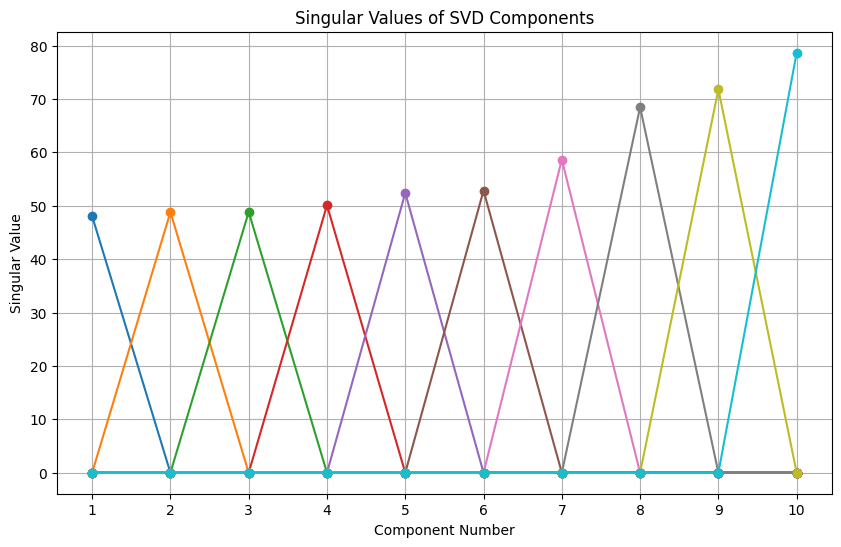

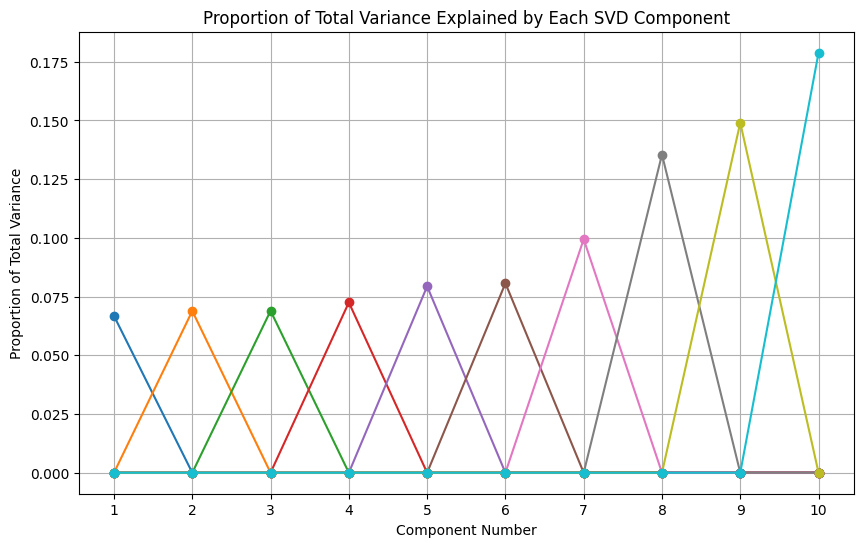

In [47]:
visulize_singular_values(mat, 10)
visulize_vairance_proportion(mat, 10)

Based on the plots, we can identify two optimal choices for using as few components as possible while retaining a significant amount of useful information: (1) 1 component, and (2) 10 components.

The calculation of variance involves squaring the singular values, which leads to a dramatic increase in variance once the singular values start to noticeably rise. Although using just 1 component is a very 'cost-effective' approach, it might not be informative enough for our purposes. Therefore, we opt to use 10 components, which provides a better balance between the number of components and the amount of information captured.

### **Visualization: TOP5 Recommendation**

Let's visualize the TOP5 recommendations of a randomly sampled user to get a taste about how our system work. The number of recommended items is adjustable.

In [48]:
# generate a sample TOP 5 recommendations
print(recommend_items(pred_df, 1515915625353294441, 5))   # picked a random customer

   product_id  lvl_of_recommend
0     3791351          0.007039
1     4102739          0.007039
2      893196          0.007039
3     4099645          0.007039
4     3642540          0.007039


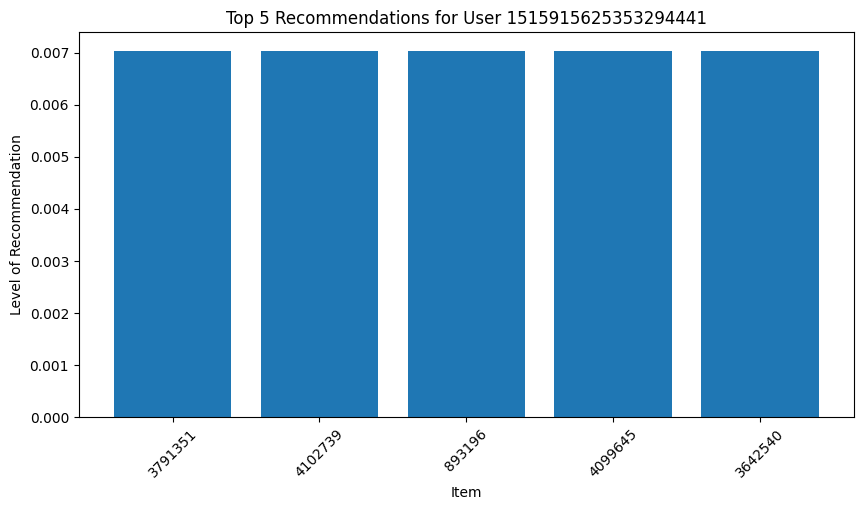

In [49]:
# To create a visualization of the Top 5 Recommendations for a user, 
# you can start by generating the recommendations using your existing recommend_items function. 
# Then, you can create a bar chart to display the recommendations. 
# Here's an implementation using matplotlib: This code snippet will generate a bar chart showing the 
# Top 5 Recommendations for the specified user, with the items on the x-axis and their corresponding 
# level of recommendation on the y-axis. 
# Remember to adjust the user ID and the number of recommendations (top_n) according to your needs.
# the 'index' column in the recommendations DataFrame must contains non-string values,

import matplotlib.pyplot as plt

# Generate recommendations for a user
user_id = 1515915625353294441
top_n = 5
recommendations = recommend_items(pred_df, user_id, top_n)
recommendations['product_id'] = recommendations['product_id'].astype(str)
# Create a bar chart of the Top 5 Recommendations
plt.figure(figsize=(10, 5))
plt.bar(recommendations['product_id'], recommendations['lvl_of_recommend'])
plt.xlabel('Item')
plt.ylabel('Level of Recommendation')
plt.title(f'Top {top_n} Recommendations for User {user_id}')
plt.xticks(rotation=45)
plt.show()

### **Visualization: Cross_Validation: The Effect of increasing components to overall prediction performance**

Increasing the number of latent factors (principal components) in PCA can sometimes improve the accuracy of a machine learning model, but it depends on the specific dataset and problem. Here's a general guideline:

If we retain too few principal components, you might lose important information from the original features, which can lead to lower accuracy. In this case, increasing the number of principal components can improve the model's performance.

If we retain too many principal components, the model may capture noise or redundant information from the original features. This can result in overfitting, where the model performs well on the training data but poorly on new, unseen data. In this case, reducing the number of principal components may improve generalization and increase the accuracy on the test data.

To determine the optimal number of principal components for your specific problem, you can perform a cross-validated grid search or experiment with different numbers of components while monitoring the model's performance on a validation dataset. This will help you find a balance between retaining important information and avoiding overfitting.

Best number of principal components: 1


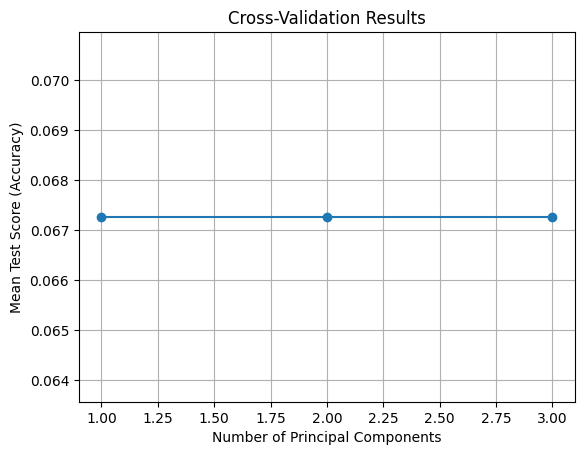

In [50]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define a range of n_components to try
param_grid = {
    'pca__n_components': np.arange(1, features.shape[1] + 1)
}

# Create a PCA object
pca = PCA()

# Create a logistic regression object
clf = LogisticRegression(max_iter=20000)

# Create a pipeline with PCA and logistic regression
pipeline = Pipeline([
    ('pca', pca),
    ('clf', clf)
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)
grid_search.fit(features, df['event_type'])

# Get the best number of principal components
best_n_components = grid_search.best_params_['pca__n_components']
print(f"Best number of principal components: {best_n_components}")


# Extract mean test scores
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Plot mean test scores against the number of principal components
plt.plot(param_grid['pca__n_components'], mean_test_scores, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Cross-Validation Results')
plt.grid()
plt.show()

The resulting plot is a horizontal line, it indicates that the mean test score (accuracy) remains constant across different numbers of principal components. This could happen due to several reasons:

Data structure: The dataset's structure might be such that the PCA transformation does not significantly affect the accuracy of the logistic regression model. This could happen when the dataset's original features are already well-separated or when the PCA is unable to capture meaningful patterns that can improve the model's performance.

Noisy data: If the dataset contains a large amount of noise or irrelevant information, PCA may fail to capture meaningful variance in the data. This can lead to a constant accuracy across different numbers of principal components.

Model insensitivity: The logistic regression model might not be sensitive enough to the changes in the principal components. This can happen if the model's parameters are poorly chosen or if another model would be more suitable for the given data.

### **Visualization: Pie Chart of Category Percentages**

Generate the top recommendations for a group of users or the entire dataset.
Calculate the percentage of recommendations in each event_type.
Create a pie chart showing the distribution of event_type in the recommendations.
Lastly, we compare this pie chart to the actual distribution of event_type in our dataset to see the holistic performance of our recommender system.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_pca,
    df['event_type'],
    test_size=0.2,
    random_state=42
)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

# make predictions on test set
y_pred = clf.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


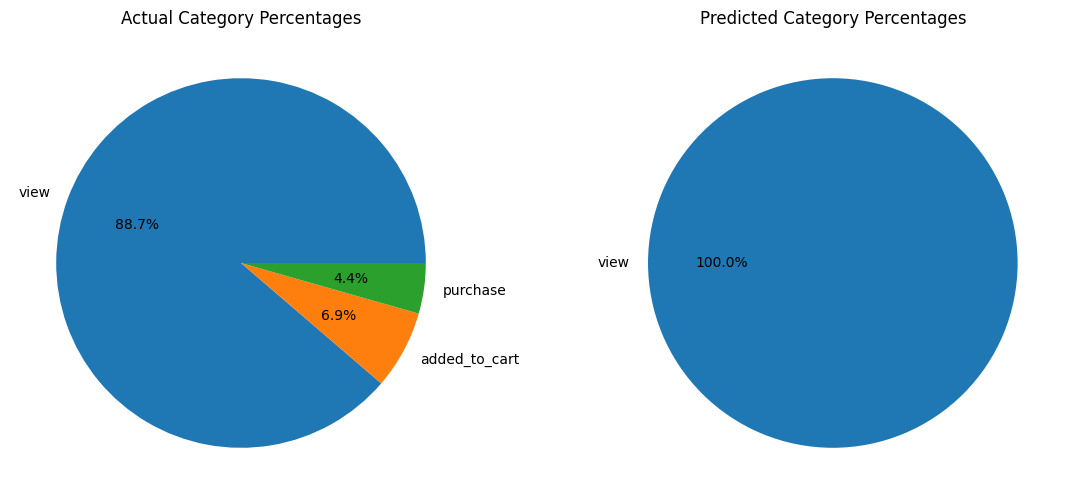

In [53]:
import matplotlib.pyplot as plt

def get_category_percentages(series):
    category_counts = series.value_counts()
    category_percentages = category_counts / category_counts.sum() * 100
    return category_percentages

# Calculate category percentages for actual and predicted data
actual_percentages = get_category_percentages(y_test)
predicted_percentages = get_category_percentages(pd.Series(y_pred))

# Create pie charts for actual and predicted category percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for actual category percentages
ax1.pie(actual_percentages, labels=['view', 'added_to_cart', 'purchase'], autopct='%1.1f%%')
ax1.set_title('Actual Category Percentages')

# Pie chart for predicted category percentages
ax2.pie(predicted_percentages, labels=['view'], autopct='%1.1f%%')
ax2.set_title('Predicted Category Percentages')
# labels=predicted_percentages.index

plt.show()

## Metrics for SVD

In [54]:
# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.8870594786988051


In [ ]:
from sklearn.metrics import recall_score
model = LogisticRegression(max_iter=10000)
# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the recall score
recall = recall_score(y_test, y_pred, average= 'weighted')
print('Recall Score: {:.2f}'.format(recall))

Recall Score: 0.89


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=10, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC score:", auc_score)

AUC score: 0.9563464058876903
